In [2]:
#import matplotlib
import matplotlib.pyplot as mp
import numpy as np
#import metpy.calc as mpc
import xarray as xr
import datetime as dt

In [4]:
#### SCRIPT TO READ IN SCAM OUTPUT AND MAKE SOME PLOTS ####
###### IOP file info. ######
#scam_file_in = './FSCAM.T42_T42.SAS.001.cam.h0.2013-06-10-43200.nc'   # input template (default: 20min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.002.cam.h0.2013-06-10-43200.nc'   # input template (5min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.003.cam.h0.2013-06-10-43200.nc'   # input template (1min tstep)
#scam_file_in = './FSCAM.T42_T42.SAS.007.cam.h0.2013-06-10-43200.nc'   # input template, fixed q for SCAM (double,kg/kg), shflx/lhflx prescribed (default: 20min tstep)
scam_file_in = './FSCAM.T42_T42.SAS.008.cam.h0.2013-06-10-43200.nc'   # as 007, but with omega,divT and divq set to zero.
#scam_file_in = './FSCAM.T42_T42.SAS.010.cam.h0.2013-06-10-43200.nc'   # as 007, but with omega,divT and divq set to zero.

scam_in = xr.open_dataset(scam_file_in,engine='netcdf4')
zoffset = 6.

#print(scam_in)
# Grab data from SCAM OP file, manipulate to trip dims and transpose
#pvar = scam_in.T.isel(lat=0,lon=0).transpose().reindex(lev=list(reversed(scam_in.lev)))


time = scam_in.time

#print(1000*86400*(scam_in.PRECC.values+scam_in.PRECL.values))


hour_frac = time.time.dt.hour+time.time.dt.minute/60.-zoffset

---- PLOTTING 1D TIME PLOTS ------>>>   Surface latent heat flux  --amin/cmax -->  0.0 375.0334


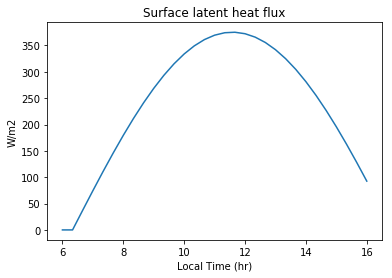

---- PLOTTING 1D TIME PLOTS ------>>>   Surface sensible heat flux  --amin/cmax -->  0.0 100.42877


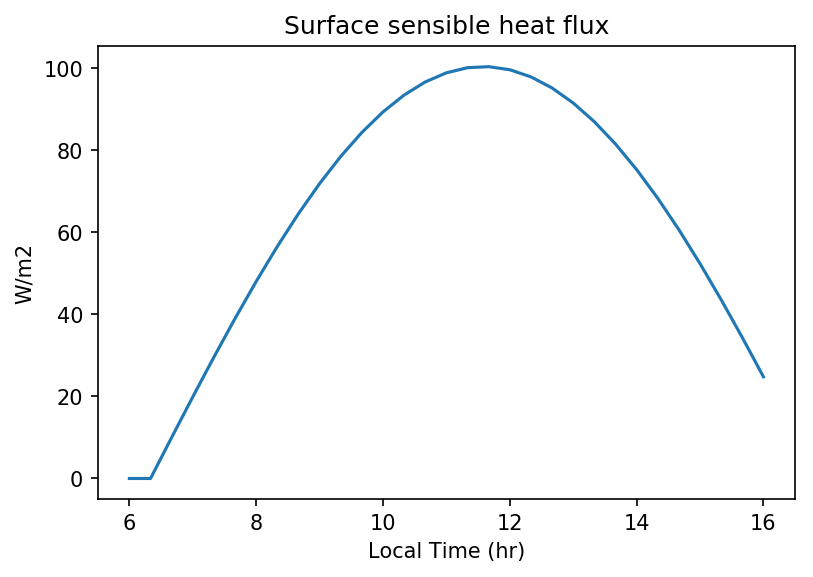

---- PLOTTING 1D TIME PLOTS ------>>>   Surface temperature (radiative)  --amin/cmax -->  288.6259 307.6696


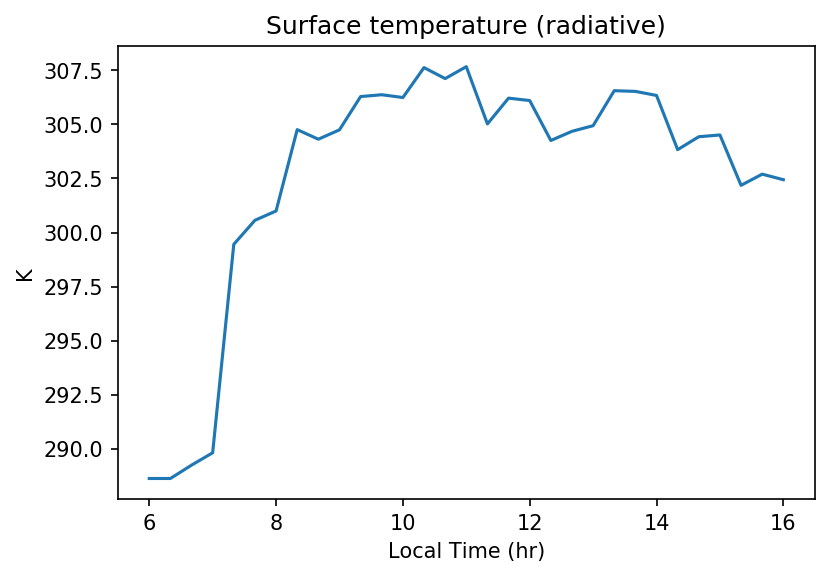

---- PLOTTING 1D TIME PLOTS ------>>>   PBL height  --amin/cmax -->  183.2189 1321.0072


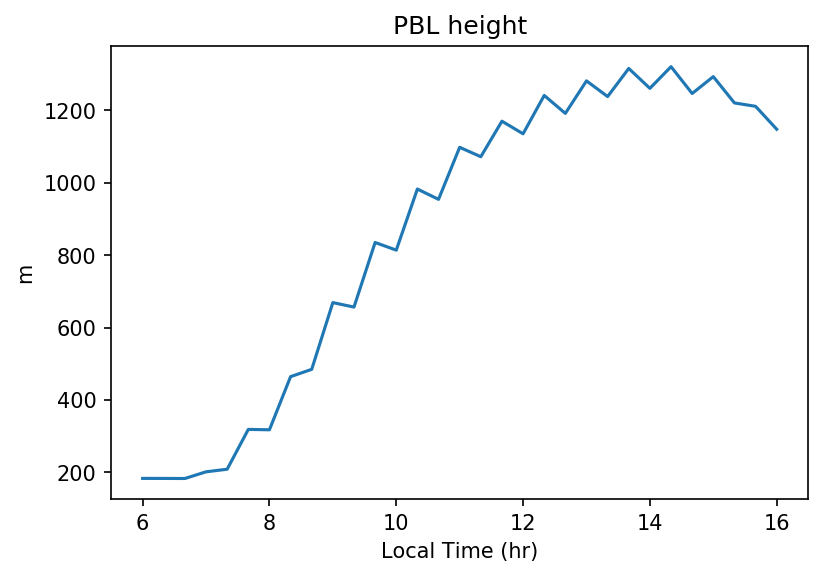

---- PLOTTING 1D TIME PLOTS ------>>>   Large-scale (stable) precipitation rate (liq + ice)  --amin/cmax -->  2.6566941e-21 7.4327583e-13


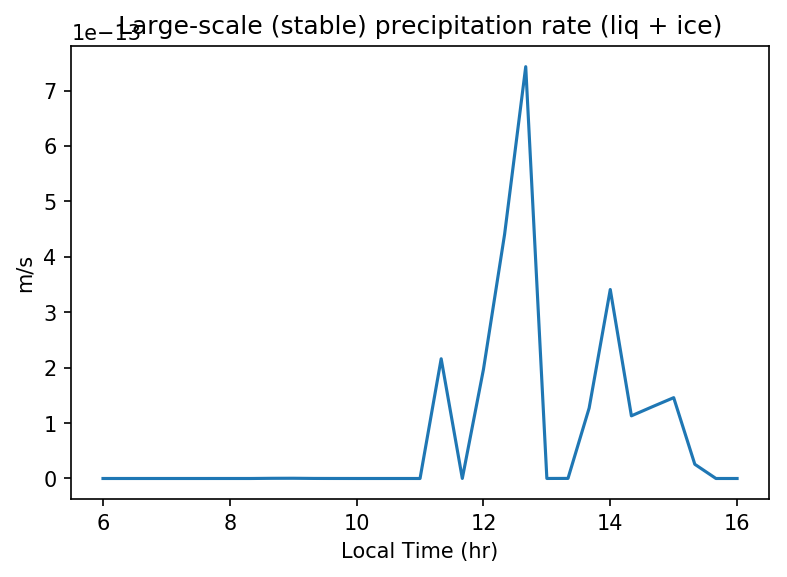

---- PLOTTING 1D TIME PLOTS ------>>>   Convective precipitation rate (liq + ice)  --amin/cmax -->  4.8747427e-08 1.0830501e-07


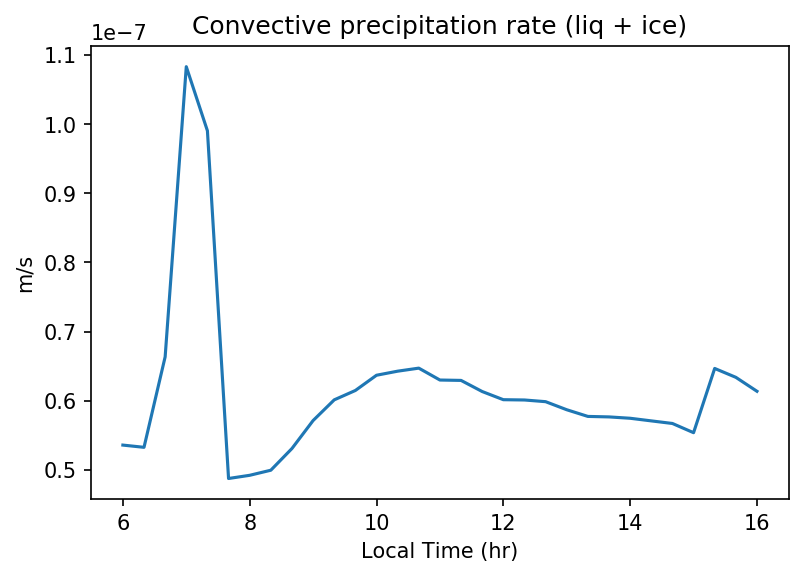

In [5]:
# Time plotting info #
## Plot Variables ##
plot1d_vars =  np.array(['LHFLX','SHFLX','TS','PBLH','PRECL','PRECC'])
cmin1d = np.array([0.,0.,290.])
cmax1d = np.array([300.,100.,310.])
vscale1d =  np.array([1.,1.,1.])


## 1D PLOTS ##

for var in plot1d_vars:
    iv = np.where(plot1d_vars==var)
    
    pvar = scam_in[var].isel(lat=0,lon=0) 
        
    # Fig setup
    print('---- PLOTTING 1D TIME PLOTS ------>>>  ',pvar.attrs['long_name'],' --amin/cmax --> ',  np.min(pvar.values),np.max(pvar.values))
    
    # Plot
    mp.plot(hour_frac,pvar)
    mp.rcParams['figure.dpi'] = 150
    
    # Axes stuff
    mp.xlabel("Local Time (hr)")
    mp.ylabel(pvar.attrs['units'])
    mp.title(pvar.attrs['long_name'])
    
    mp.show()

---- PLOTTING 2D TIME/HEIGHT PLOTS------>>>   Temperature  --amin/cmax -->  195.00325 303.44833
[190. 196. 202. 208. 214. 220. 226. 232. 238. 244. 250. 256. 262. 268.
 274. 280. 286. 292. 298. 304.]
---- PLOTTING 2D TIME/HEIGHT PLOTS------>>>   Relative humidity  --amin/cmax -->  0.0006102981 633.576
[ 10.   15.5  21.   26.5  32.   37.5  43.   48.5  54.   59.5  65.   70.5
  76.   81.5  87.   92.5  98.  103.5 109.  114.5]
---- PLOTTING 2D TIME/HEIGHT PLOTS------>>>   Cloud fraction  --amin/cmax -->  0.0 0.999
[ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90. 95.]
---- PLOTTING 2D TIME/HEIGHT PLOTS------>>>   Specific humidity  --amin/cmax -->  2.2779e-06 0.018572431
[ 1.    1.95  2.9   3.85  4.8   5.75  6.7   7.65  8.6   9.55 10.5  11.45
 12.4  13.35 14.3  15.25 16.2  17.15 18.1  19.05]
---- PLOTTING 2D TIME/HEIGHT PLOTS------>>>   Moisture Flux  --amin/cmax -->  -0.1971763 395.93002
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140.

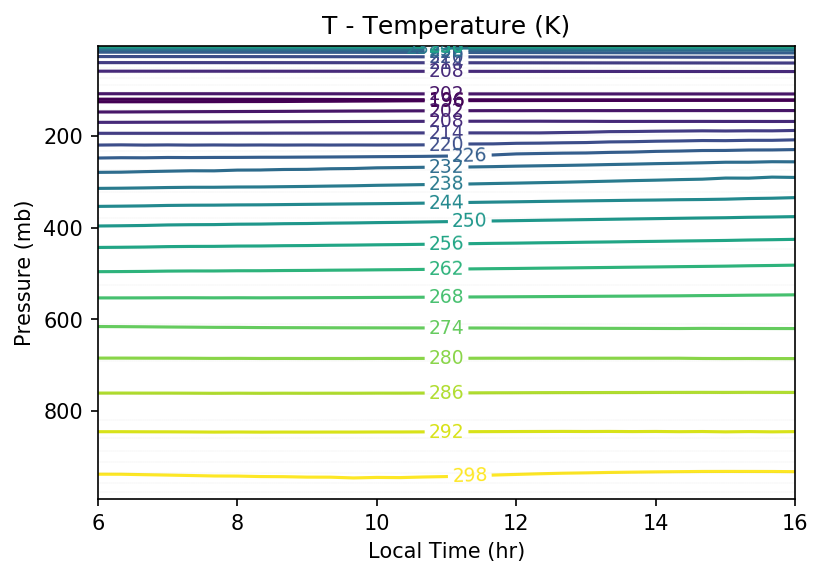

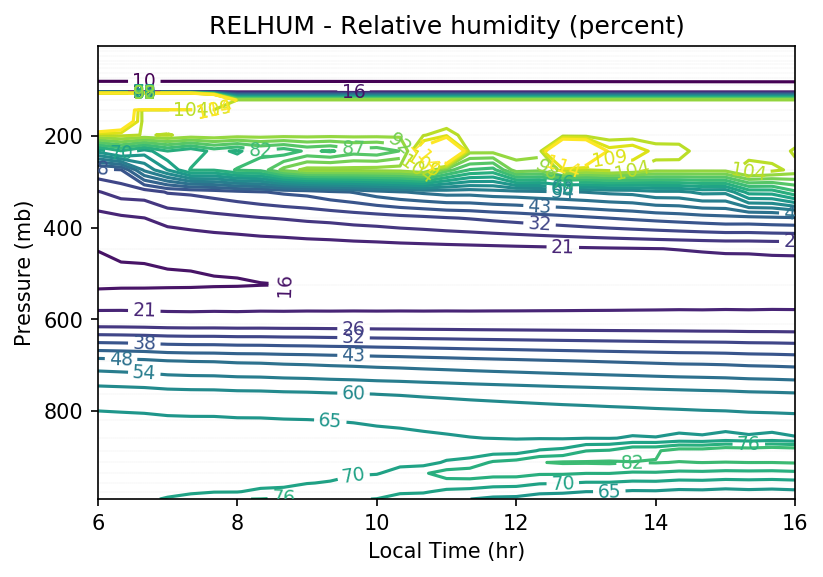

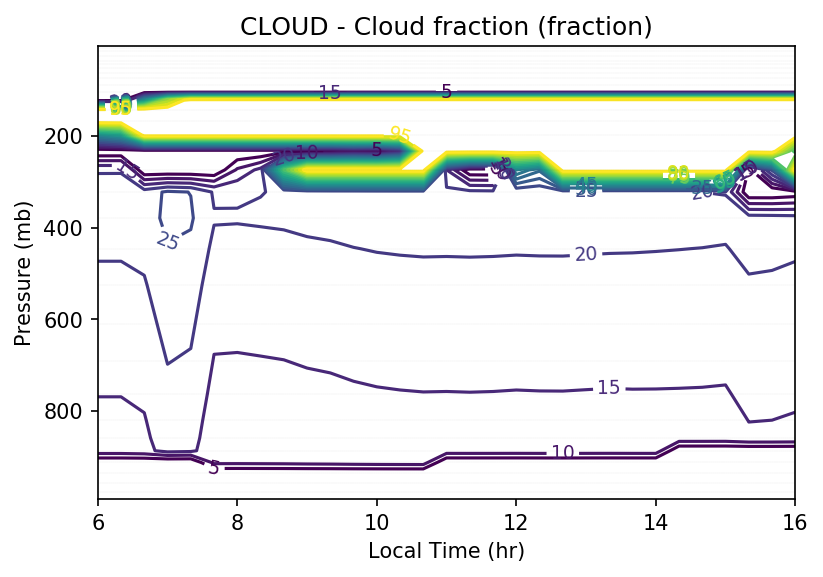

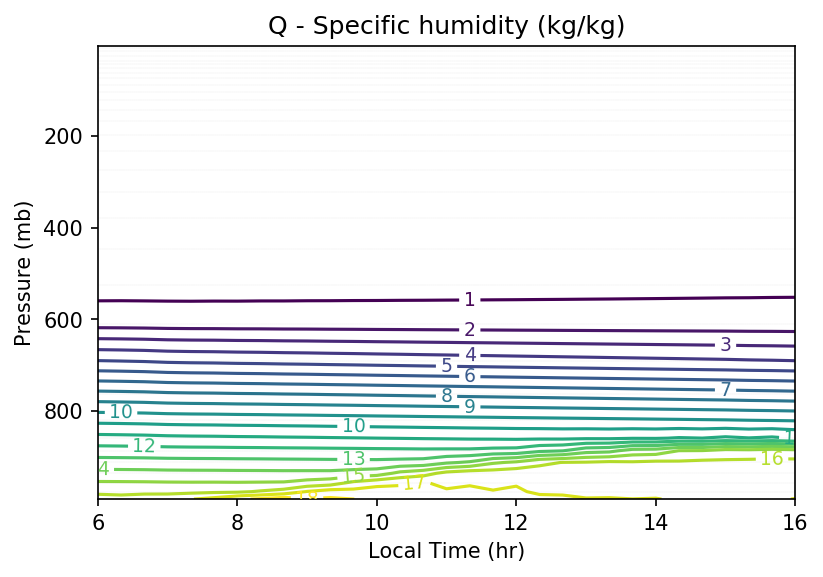

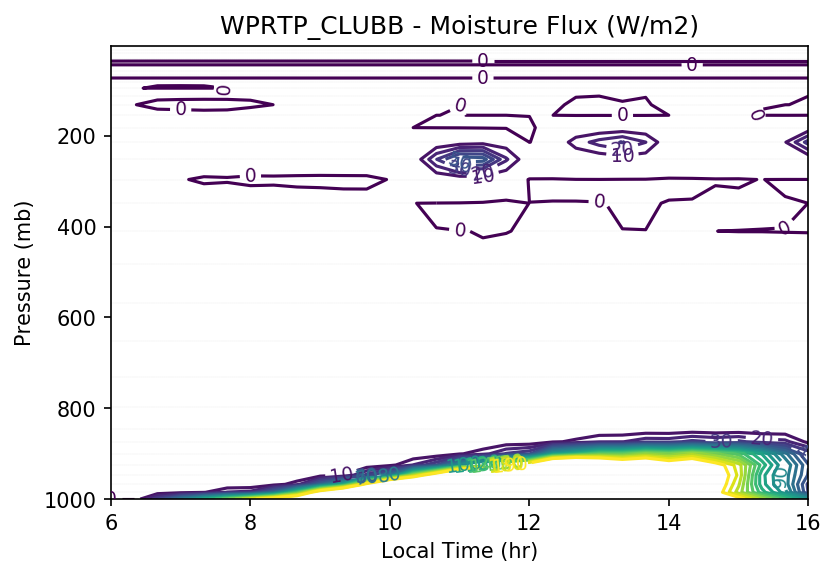

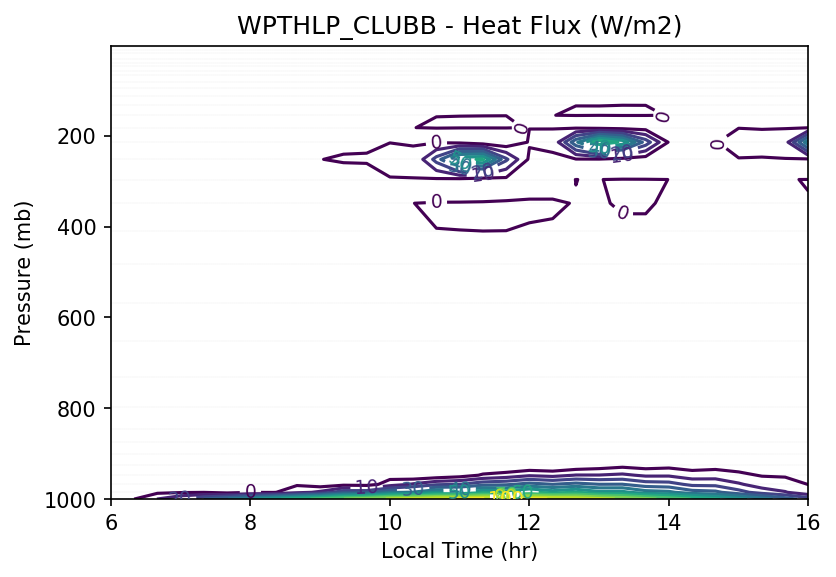

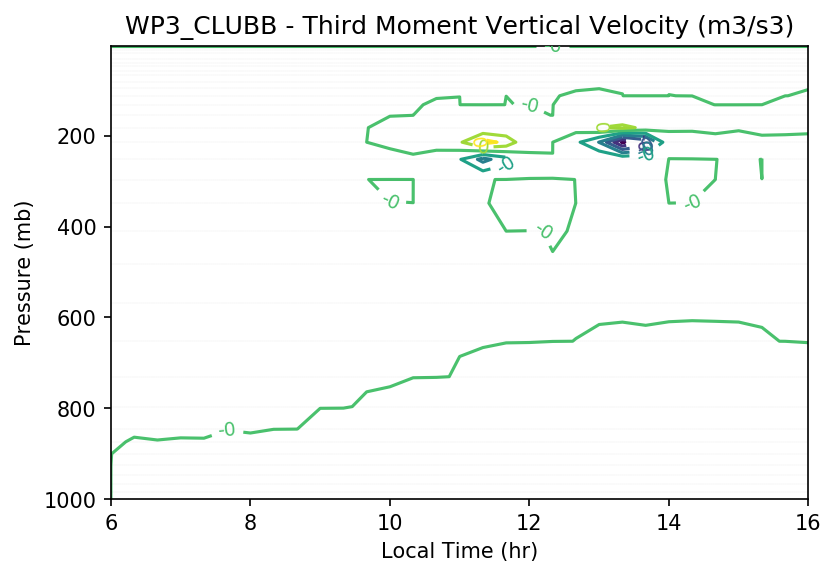

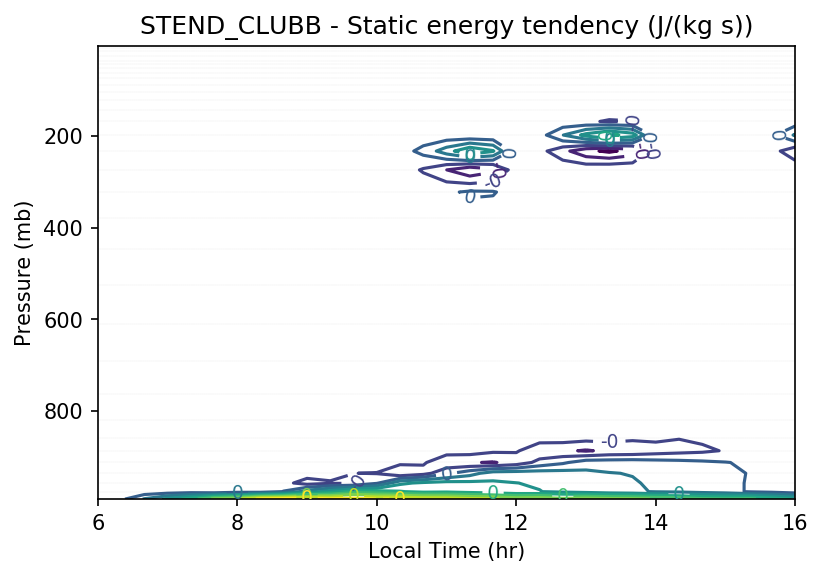

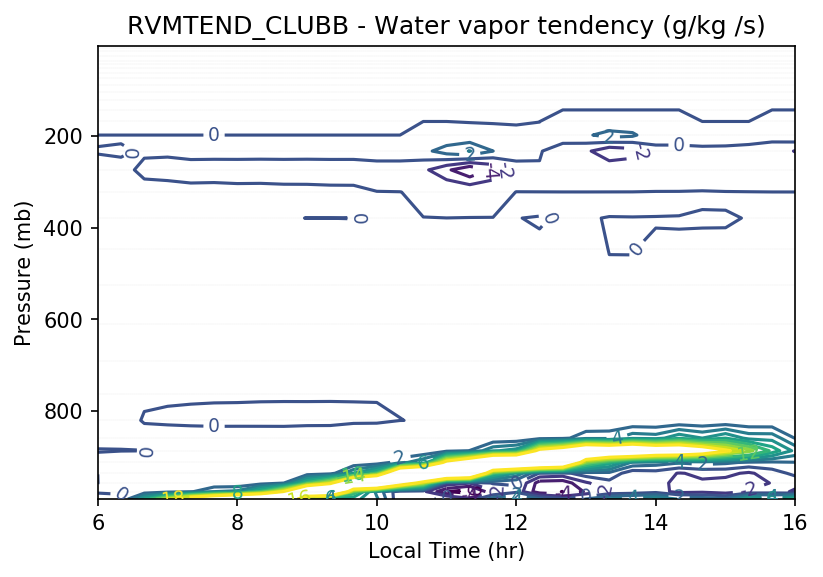

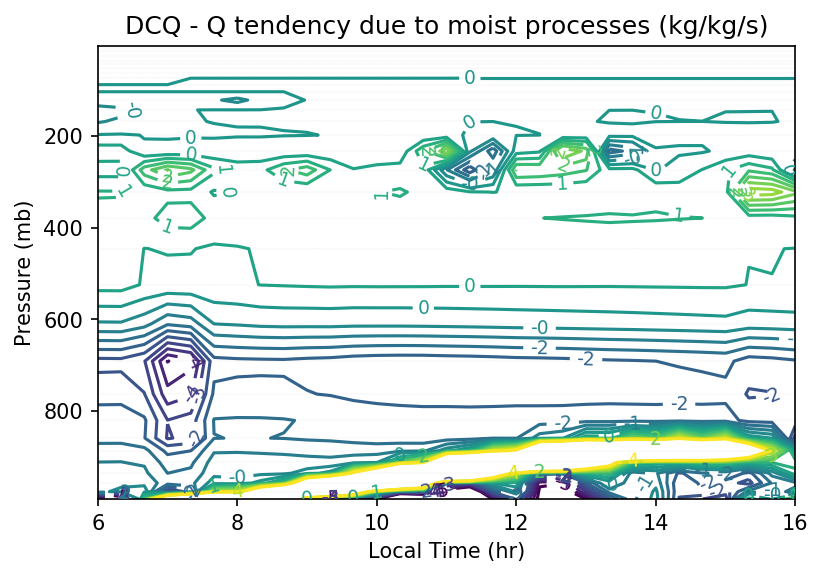

In [6]:
# Time/Height Plotting info.

plot2d_vars = np.array(['T','RELHUM','CLOUD','Q','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','STEND_CLUBB','RVMTEND_CLUBB','DCQ'])
cmin = np.array([190.,10.,  0., 1., 0,    0,-1,-0.5,-20,-5])
cmax = np.array([310.,120.,100.,20.,200.,200,1.,0.55,20,5])

vscale =  np.array([1.,1.,100.,1000.,1.,1.,1.,1.,1000.*86400,1000.*86400])

nlevs = 20 # Number of contour levels
vplevs = scam_in['lev'].transpose()

## TIME/HEIGHT PLOTTING ##

for var in plot2d_vars:
    iv = np.where(plot2d_vars==var)
 
    
    pvar = scam_in[var].isel(lat=0,lon=0).transpose()  
        
    
    print('---- PLOTTING 2D TIME/HEIGHT PLOTS------>>>  ',pvar.attrs['long_name'],' --amin/cmax --> ',  np.min(pvar.values),np.max(pvar.values))
    plevels = np.arange(cmin[iv],cmax[iv],(cmax[iv]-cmin[iv])/nlevs)
    print(plevels)
    fig,ax = mp.subplots()
    mp.rcParams['figure.dpi'] = 150
    p_tp = ax.contour(hour_frac,scam_in[pvar.dims[0]],vscale[iv]*pvar,levels=plevels)
    ax.invert_yaxis()
    mp.clabel(p_tp, fontsize=9, inline=1,fmt='%1.0f')
    mp.hlines(scam_in[pvar.dims[0]], min(hour_frac), max(hour_frac), linestyle="dotted",lw=0.04)
    ax.set_xlabel("Local Time (hr)")
    ax.set_ylabel("Pressure (mb)")
    ax.set_title(var+" - "+pvar.attrs['long_name']+" ("+pvar.attrs['units']+")")

------ SNAPSHOTS ------>>>   T  ---  Temperature  -- min/max -->  195.00325 303.44833


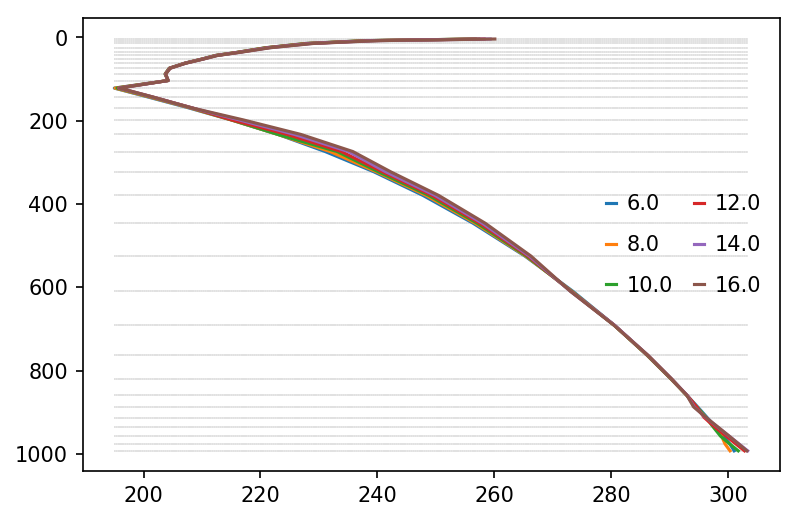

------ SNAPSHOTS ------>>>   RELHUM  ---  Relative humidity  -- min/max -->  0.0006102981 633.576


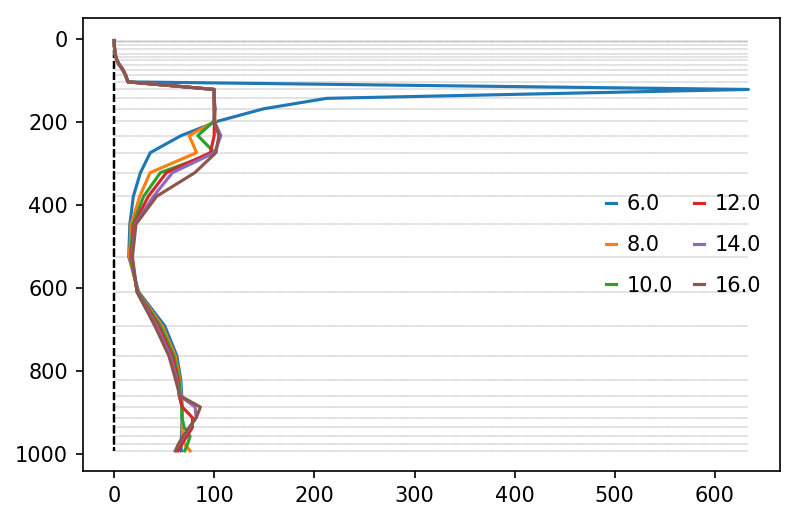

------ SNAPSHOTS ------>>>   CLOUD  ---  Cloud fraction  -- min/max -->  0.0 0.999


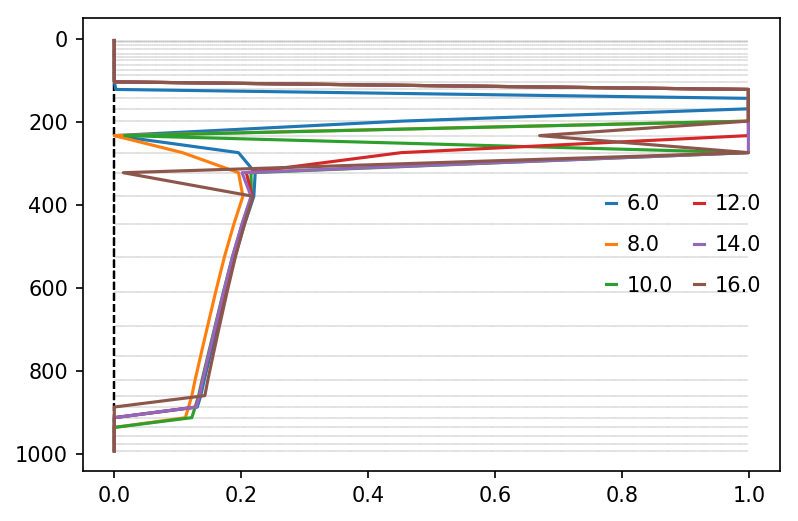

------ SNAPSHOTS ------>>>   Q  ---  Specific humidity  -- min/max -->  2.2779e-06 0.018572431


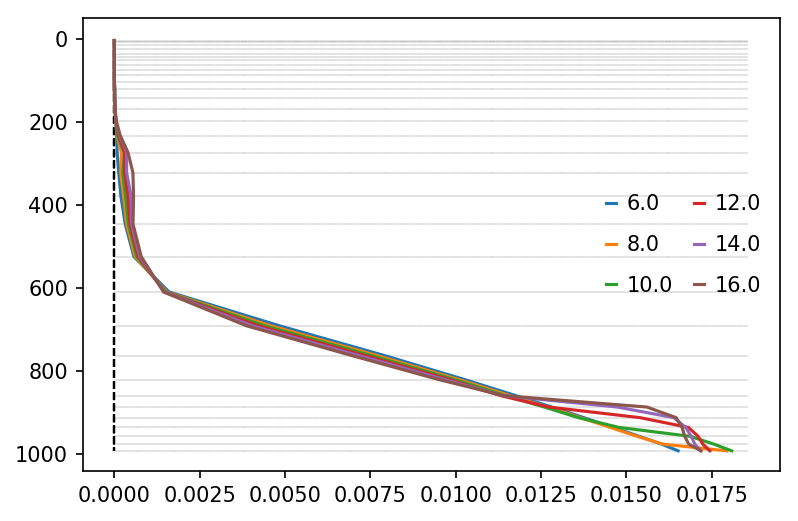

------ SNAPSHOTS ------>>>   WPRTP_CLUBB  ---  Moisture Flux  -- min/max -->  -0.1971763 395.93002


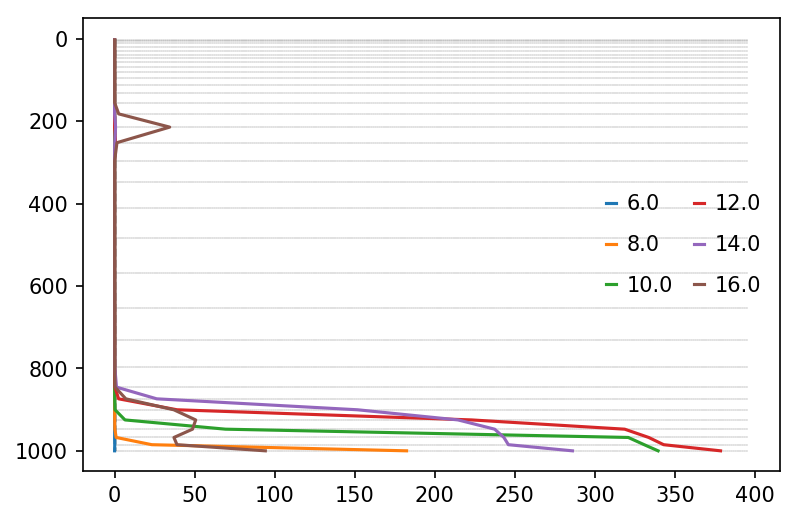

------ SNAPSHOTS ------>>>   WPTHLP_CLUBB  ---  Heat Flux  -- min/max -->  -10.3881855 102.11588


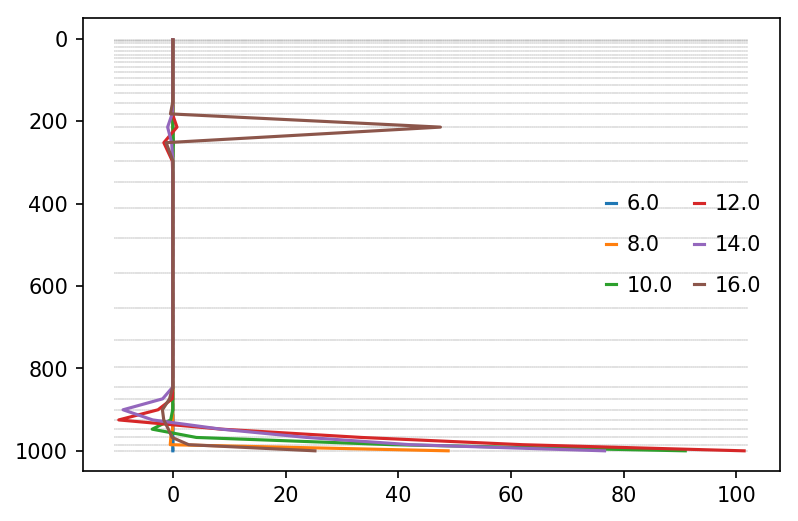

------ SNAPSHOTS ------>>>   WP3_CLUBB  ---  Third Moment Vertical Velocity  -- min/max -->  -0.5138494 0.24477778


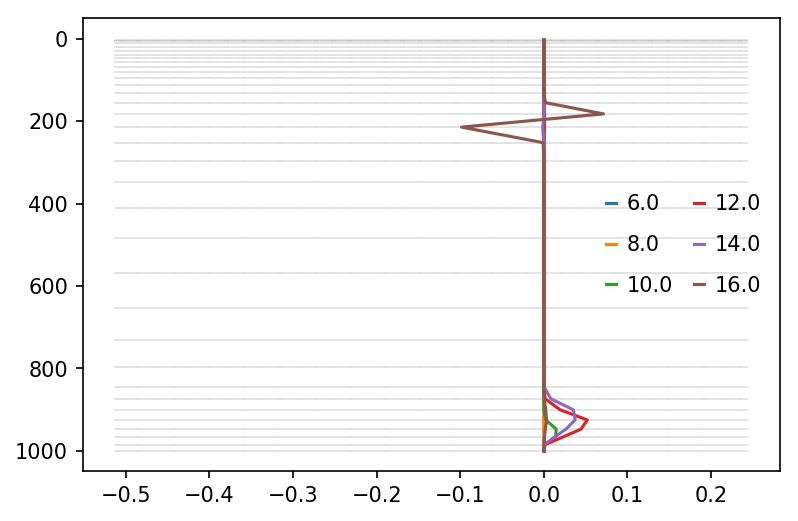

------ SNAPSHOTS ------>>>   STEND_CLUBB  ---  Static energy tendency  -- min/max -->  -0.14319326 0.43800017


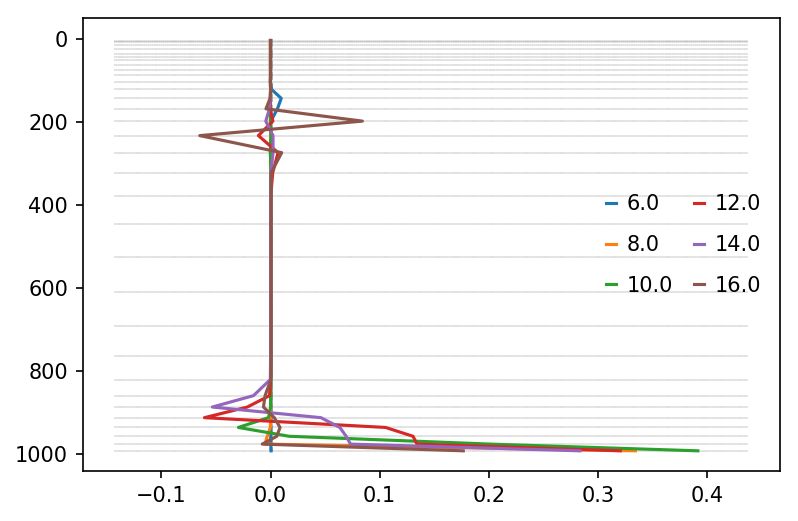

------ SNAPSHOTS ------>>>   RVMTEND_CLUBB  ---  Water vapor tendency  -- min/max -->  -8.606401e-08 4.6150592e-07


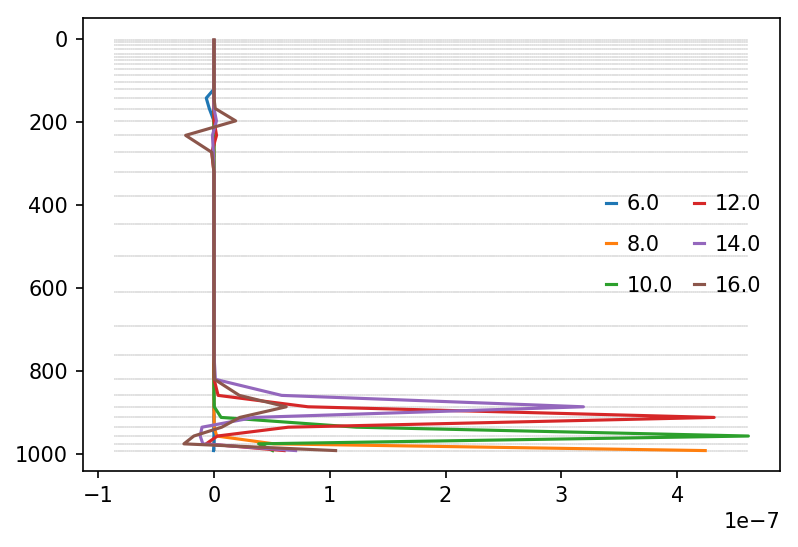

------ SNAPSHOTS ------>>>   DCQ  ---  Q tendency due to moist processes  -- min/max -->  -1.3018395e-07 4.3656294e-07


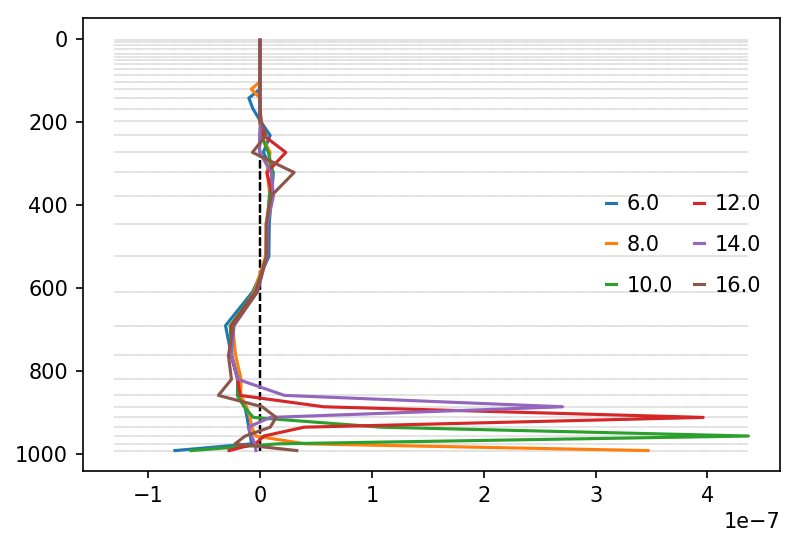

In [7]:
# Snapshots on same plot

tsnaps = np.array([6.,8.,10.,12.,14.,16])     # Time of snapshots (Z)
ntsnaps = tsnaps.size


## Loop Variables ##
for var in plot2d_vars:
    iv = np.where(plot2d_vars==var)
    
    pvar = scam_in[var].isel(lat=0,lon=0)
    print('------ SNAPSHOTS ------>>>  ',var,' --- ',pvar.attrs['long_name'],' -- min/max --> ',  np.min(pvar.values),np.max(pvar.values))

# Plot several different functions...
    
    labelspacing = []
    labels = []
       
    pplevs = scam_in[pvar.dims[1]]
        
    ## Loop times ##
    
    for ii in range(0, ntsnaps):
        itt = min(np.where(hour_frac==tsnaps[ii]))
        mp.plot(np.flip(pvar[itt[0],::-1]),scam_in[pvar.dims[1]])
        
        if var !='T': mp.vlines(0, 0, scam_in[pvar.dims[1]].max(), linestyle="dashed",lw=1)
        mp.hlines(scam_in[pvar.dims[1]], pvar.min(), pvar.max(), linestyle="dotted",lw=0.04)
        
#        labels.append(r'$y = %ix + %i$' % (ii, ii+1))
   
# Legend
#    mp.legend(labels=tsnaps, ncol=ntsnaps, loc="upper right")
    mp.legend(labels=tsnaps, ncol=2, loc="center right", 
            columnspacing=1.0, labelspacing=1, 
            handletextpad=0.5, handlelength=0.5, frameon=False)
#            fancybox=False, shadow=False)
    mp.gca().invert_yaxis()
    mp.show()
    

In [8]:

<b>Current Issues</b> <br>
-Raditaion timestepping <br>
-Lower stratosphere specificaions <br>
-Land surface spin-up (repeating diurnal cycles) <br>
-Aerosol specifications <br>



SyntaxError: invalid syntax (<ipython-input-8-8301adeb5fb5>, line 2)